### Градиентный бустинг

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from matplotlib.colors import ListedColormap
import scipy.stats as sts
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

Случайный лес (минусы):
- усреднение глубоких деревьев
- базовые алгоритмы независимы (не направлены)

#### Бустинг
- последовательное обучение базовых алгоритмов
- каждый следующий исправляет ошибки предыдущих
- за счет этого достаточно простых базовых алгоритмов
- слабые алогритмы - ***weak learn*** (пни, глубина дерева (2-8))
- переобучается (в отличие от случайного леса, риск случайного блуждания в пространстве)
- два гиперпараметра (число алгоритмов, размер шага)
- стохастический градиентный бустинг ***(bagging)***

$b_0(x)$ - первый алгоритм в композиции: 

- $b_0(x) = 0$
- $b_0(x) = \frac 1 l \sum\limits_{i=1}^{l} y_i$
- $b_0(x) = \underset {y \in Y}{argmax}\sum\limits_{i=1}^{l}[y_i = y]$

Задача:

- $a_{N-1} = \sum\limits_{k=1}^{N-2} b_k(x) + b(x)$
- $
\sum\limits_{i=1}^l L[y_i, a_{N-1}(x_i) + b(x_i)] 
    \rightarrow \underset {b} {min}
$

Пусть $s = (s_1, ..., s_l)$ - вектор сдвигов, $h \in (0, 1]$ :
-  $F(s) = \sum\limits_{i=1}^l L[y_i, a_{N-1}(x_i) + h \cdot s_i] 
\rightarrow \underset {s} {min}$

$s = \big[ - L_z^{'}(y_i, a_{n-1}(x_i)) \big]_{i=1}^l$

#### Пример регрессии: Бустинг для MSE

$
\begin{array}{|c|c|с|c|c|}
\hline 
\text{ответы}   & y_1 & y_2  & ...   & y_n  \\ \hline
\text{прогнозы} & b_1(x_1) & b_1(x_2) & ... & b_1(x_n)  \\ \hline
\text{поправки} & y_1 - b_1(x_1) & y_2 - b_1(x_2) & ... & 
y_n - b_1(x_n)  \\ \hline
\end{array}
$

$
b_1(x)=\underset{b}{\text{argmin}} \frac{1}{l}
\sum\limits_{i=1}^{l}(b(x_i)-y_i)^2
$
$
b_2(x)=\underset{b}{\text{argmin}} \frac{1}{l}
\sum\limits_{i=1}^{l}[b(x_i)-(y_i - b_1(x_i)]^2
$
$
b_N(x)=\underset{b}{\text{argmin}} \frac{1}{l}
\sum\limits_{i=1}^{l}[b(x_i)-
    (y_i - \sum\limits_{k=1}^{N-1}b_k(x_i))]^2
$

Пусть $L-MSE$
- $L(a, X) = \frac 1 l \sum\limits_{i=1}^{l}(y_i - a(x_i))^2$
- $L(y, z) = (y - z)^2$
- $L_z^{'}(y, z) = 2(z-y)$
- $s = \big(-2(a_{N-1}(x_1) - y_1), ..., -2(a_{N-1}(x_l) - y_l)\big)$

In [3]:
np.random.seed(32)
def grad(y, p):
    return 2*(p - y)

def f(x):
    return np.cos(x)

n = 10
X = np.linspace(-5, 5, n).reshape(-1, 1)
Y = f(X) + sts.norm(0, 0.25).rvs(n).reshape(-1, 1) + 2

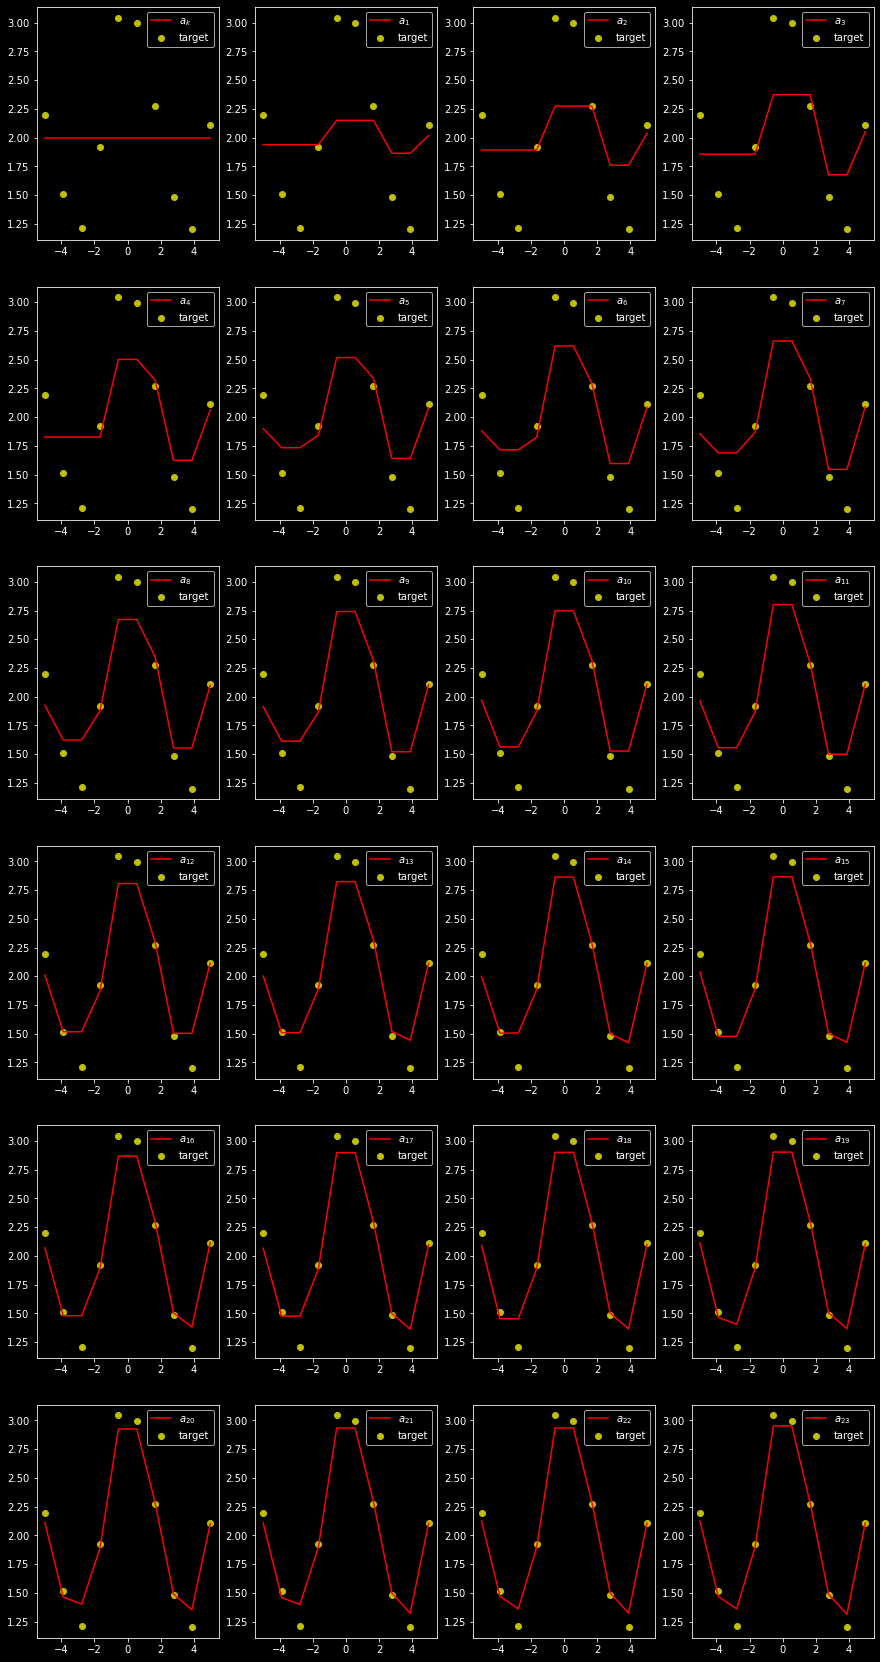

In [4]:
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(15, 30))

eta = 0.1  # learning rate
b = Y.mean()*np.ones(n).reshape(-1, 1) # initialize boosting

# base model with constant values
k = 0 
a = b.copy()   
axes[k // 4, k % 4].scatter(X, Y, color='y', label='target')
axes[k // 4, k % 4].plot(X, a, color='r', label=f'$a_{{k}}$')
axes[k // 4, k % 4].legend()

# boost our ensemble
for k in range(1, 24):

    tree = DecisionTreeRegressor(max_depth=2, random_state=32)
    agrad = -grad(Y, a).reshape(-1, 1)
    tree.fit(X, agrad)
    pred = tree.predict(X).reshape(-1, 1)
    a += pred*eta
    
    label = '$a_{{{}}}$'.format(k)
    axes[k // 4, k% 4].scatter(X, Y, color='y', label='target')
    axes[k // 4, k % 4].plot(X, a, color='r', label=label)
    axes[k // 4, k % 4].legend()

#### Бустинг для логистической ошибки

- $X = (x_i)_{i=1}^l, \; Y = (y_i)_{i=1}^l$
- $L(a(X), Y) = \sum\limits_{i=1}^l log(1+exp(-y_ia(x_i)))$
- $s = (L_{a(x_i)}^{'}(a(x_i, y_i))_{i=1}^l= \bigg(-\frac{y e^{-y_ia(x_i)}}{1 + e^{-y_ia(x_i)}}\bigg)_{i=1}^l = \bigg(-\frac{y}{1 + e^{y_ia(x_i)}}\bigg)_{i=1}^l$